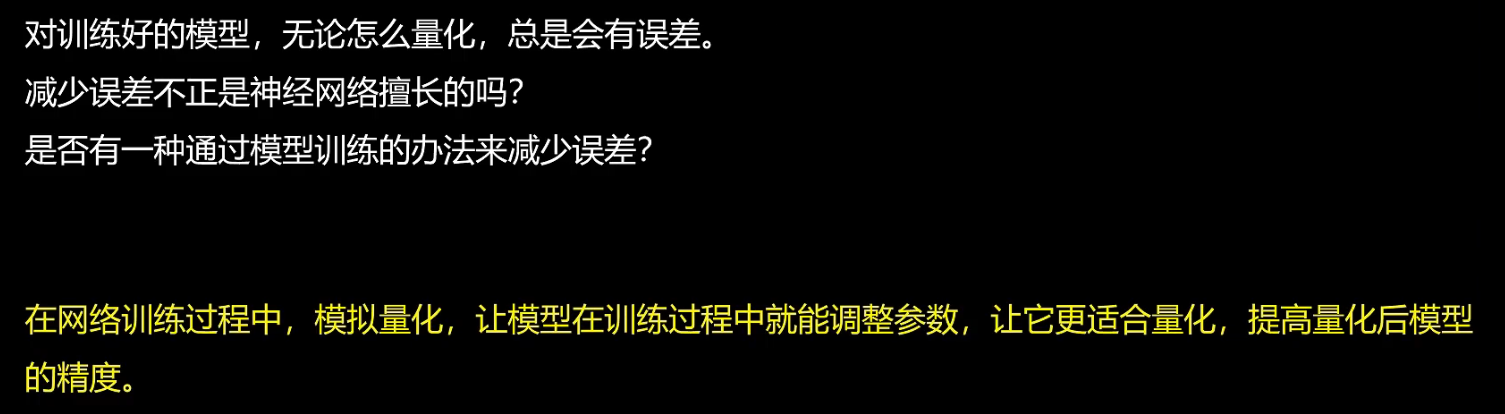

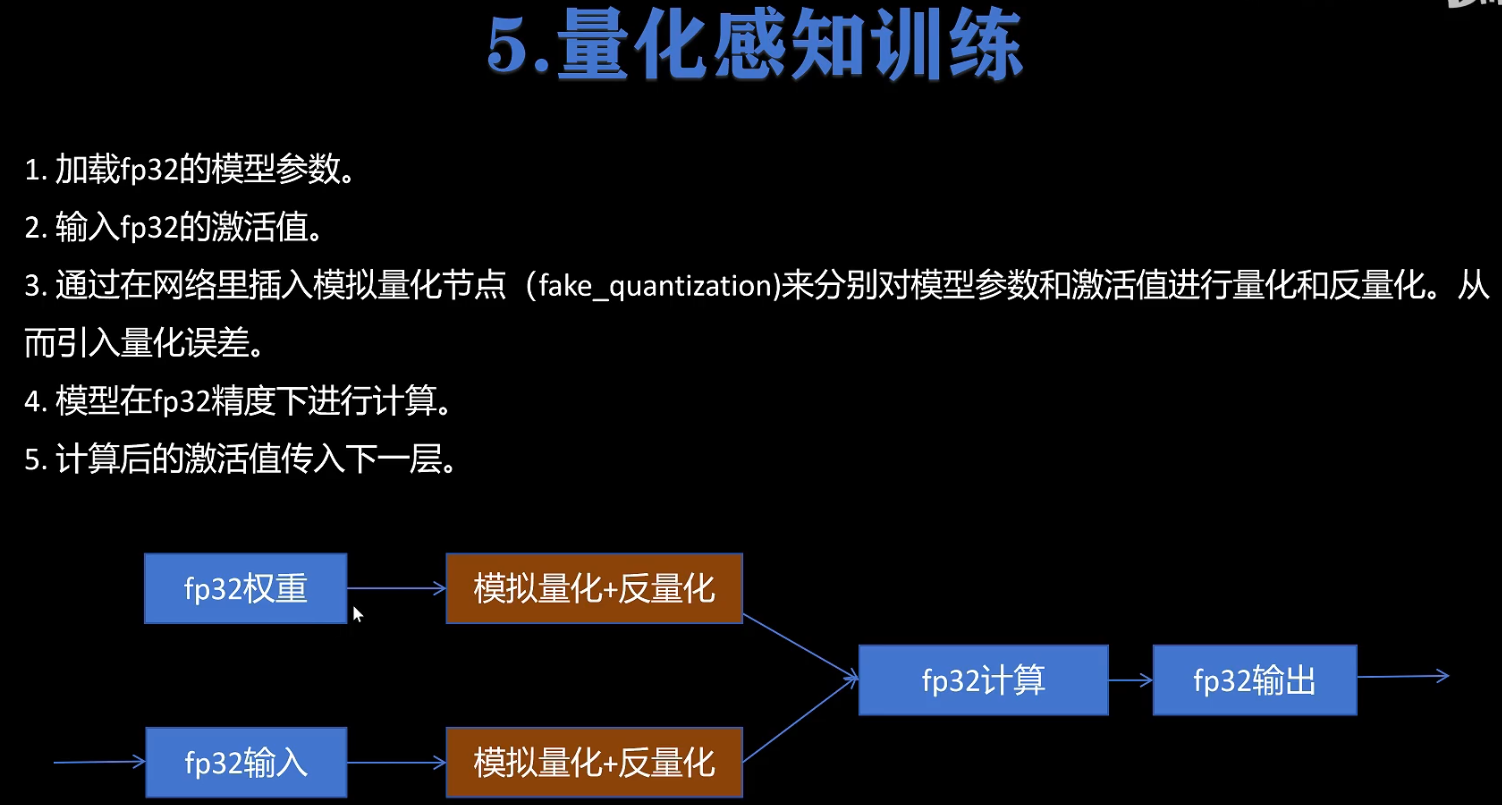



In [1]:
import torch

torch.manual_seed(123)

# QuantStub和DeQuantStub是为了支持静态量化和量化感知训练(Quantization Aware Training)而设计的。它们帮助标记模型中哪些地方应该开始量化，哪些地方应该停止量化。
# 在量化过程中，这些桩会被替换为实际的量化/反量化操作。例如，在推理时，QuantStub会将浮点输入转换为量化表示（通常是 int8），而DeQuantStub则会在输出前将量化表示转回浮点数。
class MyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.quant = torch.ao.quantization.QuantStub()  # 量化点位符
        self.linear1 = torch.nn.Linear(3, 3, bias=False)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(3, 1, bias=False)
        self.dequant = torch.ao.quantization.DeQuantStub()  # 反量化占位符

    def forward(self, inputs):
        q_inputs = self.quant(inputs)  # 量化
        outputs = self.linear1(q_inputs)
        outputs = self.relu(outputs)
        outputs = self.linear2(outputs)
        f_outputs = self.dequant(outputs)  # 反量化
        return f_outputs

In [2]:
model = MyModel()

In [3]:
# 构造训练数据

# weights是一个3行1列的矩阵
weights = torch.tensor([[1.1], [2.2], [3.3]])
print(weights.shape)

# training_features是一个12000行3列的矩阵，代表12000个样本，每个样本有3个特征值。
training_features = torch.randn(12000, 3)
print(training_features.shape)

# 训练样本与权重做矩阵乘法，得到training_labels，其形状为(12000, 1)
training_labels = training_features @ weights
print(training_labels.shape)

torch.Size([3, 1])
torch.Size([12000, 3])
torch.Size([12000, 1])


In [4]:
# 构造测试数据

# 测试数据集形状为(1000, 3)
test_features = torch.randn(1000, 3)
print(test_features.shape)

# 测试数据集标签形状为(1000, 1)
test_labels = test_features @ weights
print(test_labels.shape)

torch.Size([1000, 3])
torch.Size([1000, 1])


In [5]:
# 设定量化配置
model.qconfig = torch.ao.quantization.get_default_qconfig('x86')
# 准备量化感知训练模型
model_prepared = torch.ao.quantization.prepare_qat(model)   # 注意：这个函数与训练后静态量化使用的orch.ao.quantization.prepare(model)不同

optimizer = torch.optim.Adam(model_prepared.parameters(), lr=0.1)  # 注意，优化器指定的模型是model_prepared，而不是model

/home/haoyu/anaconda3/envs/INT8/lib/python3.12/site-packages/torch/ao/quantization/observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [6]:
for i in range(100):
    preds = model_prepared(training_features)
    loss = torch.nn.functional.mse_loss(preds, training_labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

In [7]:
# 模型评估
model_prepared.eval()
with torch.no_grad():
    preds = model_prepared(test_features)
    mse = torch.nn.functional.mse_loss(preds, test_labels)
    print(f"float32 model testing loss:{mse.item():.3f}")

float32 model testing loss:0.001


In [8]:
model_int8 = torch.ao.quantization.convert(model_prepared)

In [9]:
print("float32 model linear1 parameter:\n", model_prepared.linear1.weight)
print("\nint8 model linear1 parameter (int8):\n", torch.int_repr(model_int8.linear1.weight()))
print("\nint8 model linear1 parameter:\n", model_int8.linear1.weight())


float32 model linear1 parameter:
 Parameter containing:
tensor([[ 0.7387,  1.4585,  2.1794],
        [-0.7526, -1.5223, -2.0909],
        [-0.4093, -0.6998, -1.4874]], requires_grad=True)

int8 model linear1 parameter (int8):
 tensor([[  42,   84,  125],
        [ -46,  -93, -127],
        [ -34,  -57, -122]], dtype=torch.int8)

int8 model linear1 parameter:
 tensor([[ 0.7319,  1.4638,  2.1782],
        [-0.7544, -1.5251, -2.0827],
        [-0.4143, -0.6946, -1.4866]], size=(3, 3), dtype=torch.qint8,
       quantization_scheme=torch.per_channel_affine,
       scale=tensor([0.0174, 0.0164, 0.0122], dtype=torch.float64),
       zero_point=tensor([0, 0, 0]), axis=0)


In [10]:
# 评估 int8 模型
with torch.no_grad():
    preds = model_int8(test_features)
    mse = torch.nn.functional.mse_loss(preds, test_labels)
    print(f"int8 model testing loss: {mse.item():.3f}")

int8 model testing loss: 0.016
